In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
from tueplots import bundles

# from configs.configs import get_circles_brownian_config
from configs.configs import get_circles_eulerian_independent_config
from src.data.synthetic import Circle
from src.models.diffusion.diffuser import Diffuser1D
from src.models.diffusion.sde import SDE
from src.utils.trainer import TrainerModule, Model
from src.utils.plotting import plot_trajectories

# LOAD_PATH = "../results/circle_brownian_g2score/"
LOAD_PATH = "../results/circle_eulerian_independent_g2score/"

In [3]:
# Some plot settings for NeuraIPS
# plt.rcParams.update(
#     bundles.neurips2024(
#         family="sans-serif",
#         usetex=False,
#     ))
# plt.rcParams.update({"xtick.labelsize": 14, "ytick.labelsize": 14})
# # update the label font size
# plt.rcParams.update({"axes.labelsize": 14})
cmap = colormaps.get_cmap("RdYlBu")
colors = cmap(jnp.linspace(0, 1, 200))
start_color, end_color = colors[0], colors[-1]

In [4]:
X0 = Circle(r=1.0)
XT = Circle(r=1.5)

# config = get_circles_brownian_config()
config = get_circles_eulerian_independent_config()
config.training.dir = LOAD_PATH
config.sde.X0 = X0
config.diffusion.matching_obj = "g2score"
sde = SDE(**config.sde)
rng_key = jax.random.PRNGKey(config.training.seed)

In [5]:
trainer = TrainerModule(config)
# model = Model(trainer, dim=1)
diffuser = Diffuser1D(config.training.seed, sde=sde, dt=config.diffusion.dt)

In [22]:
# unconditional process
n_eval_pts = 32
ys = diffuser.solve_sde(rng_key, jnp.zeros((n_eval_pts*2)), noise_scaling="none", weighting_output="id")[0]
ys = X0.sample(n_eval_pts)[None, :] + ys.reshape(50, -1, 2)

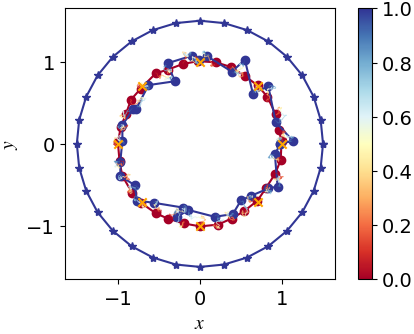

In [23]:
fig, ax = plt.subplots()
plot_trajectories(dim=2, ax=ax, traj=ys, target=XT.sample(n_eval_pts), cmap_name="RdYlBu")
ax.scatter(*X0.sample(8).T, color="#FFA500", marker="x", zorder=2)
ax.set_aspect("equal")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax)
fig.savefig("../assets/circle_brownian_unconditional.pdf", bbox_inches="tight", dpi=150)

In [24]:
class TrueModel(Model):
    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return -x/t
    
trainer = TrainerModule(config)
true_model = TrueModel(trainer)
true_diffuser = Diffuser1D(config.training.seed, sde=sde)

In [28]:
n_eval_pts = 64

y0 = (XT.sample(n_eval_pts) - X0.sample(n_eval_pts)).flatten()
ts = jnp.linspace(0.0, 1.0, 200)
ys = trainer.diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model)

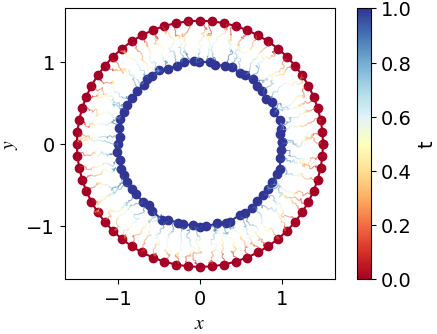

In [29]:
ys = ys.reshape((ys.shape[0], n_eval_pts, 2))
fig, ax = plt.subplots()
plot_trajectories(dim=2, 
                  ax=ax, 
                  traj=ys + X0.sample(n_eval_pts)[None, :],
                  target=None,
                  cmap_name="RdYlBu")
ax.set_aspect("equal")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("t")
fig.savefig("../assets/circle_brownian_true.pdf", bbox_inches="tight", dpi=150)

In [6]:
trainer.train_model(pretrained=True)
est_model = Model(trainer)

In [7]:
# conditional process
n_eval_pts = 10_000

y0 = (XT.sample(n_eval_pts) - X0.sample(n_eval_pts)).flatten()
ts = jnp.linspace(0.0, 1.0, 100)
ys = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(config.training.seed), x0=y0, ts=ts, model=est_model)

In [8]:
%timeit ys = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(config.training.seed), x0=y0, ts=ts, model=est_model)

2.74 s ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
ys_ = ys.reshape((ys.shape[0], n_eval_pts, 2))
ys_ = ys_ + X0.sample(n_eval_pts)[None, :]
# fig, ax = plt.subplots()
# plot_trajectories(dim=2, 
#                   ax=ax, 
#                   traj=ys_ + X0.sample(n_eval_pts)[None, :],
#                   target=None,
#                   cmap_name="RdYlBu")
# ax.set_aspect("equal")
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label("t")
# fig.savefig("../assets/circle_brownian_est.pdf", bbox_inches="tight", dpi=150)

In [10]:
# import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from IPython import display

# plt.rcParams['animation.ffmpeg_path'] = 'yourhomepath/anaconda2/envs/yourenv/bin/ffmpeg' 

cmap = colormaps.get_cmap("RdYlBu")
colors = cmap(jnp.linspace(0, 1, len(ts)))
# Turn off matplotlib plot in Notebook
plt.ioff()

fig, ax = plt.subplots()

line, = ax.plot([],'o', markersize=1)

ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.7, 1.7)
ax.set_aspect('equal')


def animate(i):
    line.set_data((ys_[i][:,0],ys_[i][:,1]))
    line.set_color(colors[i])
    ax.set_title(f"t = {ts[i]:.2f}")
    return line

# animate(0)
# plt.show()

anim = FuncAnimation(fig, animate, frames=len(ts), interval=100)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [49]:
# Plot the score
xs = jnp.array([ys[i] for i in [40, 80, 120, 160]])
ts = jnp.array([0.2, 0.4, 0.6, 0.8])
true_scores = jax.vmap(lambda t, x: true_model(t, x))(ts, xs)
est_scores = jax.vmap(lambda t, x: est_model(t, x))(ts, xs)
true_scores = true_scores.reshape((-1, n_eval_pts, 2))
est_scores = est_scores.reshape((-1, n_eval_pts, 2))

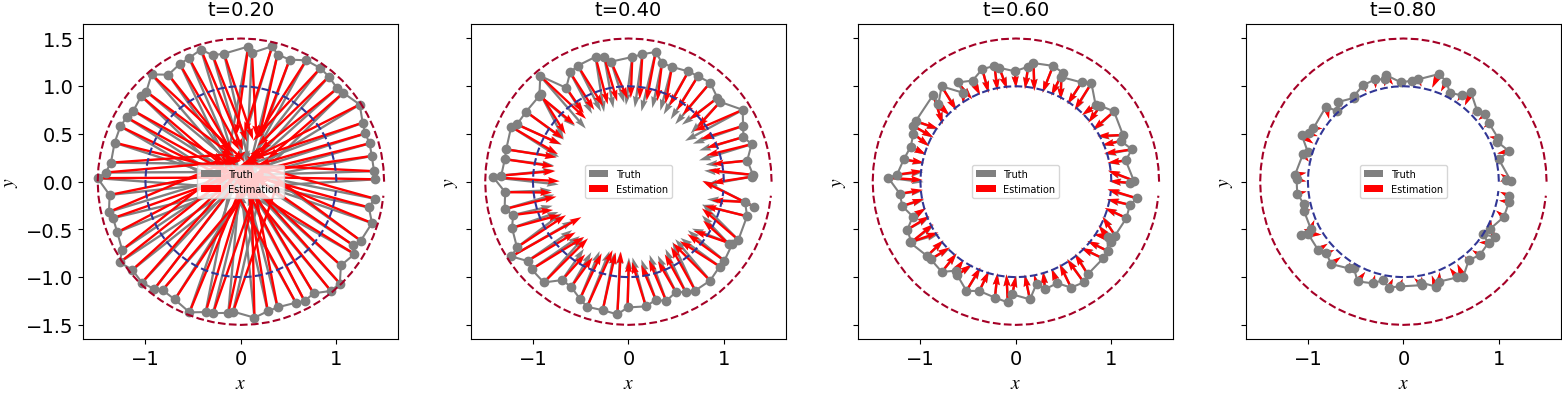

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
for i in range(4):
    ax[i].plot(*((xs[i].reshape((n_eval_pts, 2))) + X0.sample(n_eval_pts)).T, marker="o", color="grey")
    ax[i].plot(*XT.sample(n_eval_pts).T, linestyle="--", color=start_color)
    ax[i].plot(*X0.sample(n_eval_pts).T, linestyle="--", color=end_color)
    ax[i].quiver(*((xs[i].reshape((n_eval_pts, 2))) + X0.sample(n_eval_pts)).T, *true_scores[i].reshape((n_eval_pts, 2)).T, color="grey", scale=5, label="Truth")
    ax[i].quiver(*((xs[i].reshape((n_eval_pts, 2))) + X0.sample(n_eval_pts)).T, *est_scores[i].reshape((n_eval_pts, 2)).T, color="r", scale=5, label="Estimation")
    ax[i].set_aspect("equal")
    ax[i].set_xlabel(r"$x$")
    ax[i].set_ylabel(r"$y$")
    ax[i].legend()
    ax[i].set_title(f"t={ts[i]:.2f}", fontsize=14)
fig.savefig("../assets/circle_brownian_scores.pdf", bbox_inches="tight", dpi=150)

In [65]:
# More samples
n_sim = 4
n_eval_pts = 32
ts = jnp.linspace(0.0, 1.0, 200)
rng_keys = jax.random.split(rng_key, n_sim*2)
y0s = jax.vmap(lambda key1, key2: (XT.sample(n_eval_pts, key1) - X0.sample(n_eval_pts, key2)).flatten())(rng_keys[n_sim:], rng_keys[:n_sim])
yss = jax.vmap(lambda rng_key, y0: trainer.diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys[n_sim:], y0s)
yss32 = yss.reshape((n_sim, len(ts), n_eval_pts, 2)) + X0.sample(n_eval_pts)[None, None, :]
print(yss32.shape)

(4, 200, 32, 2)


In [66]:
n_sim = 4
n_eval_pts = 64
ts = jnp.linspace(0.0, 1.0, 200)
rng_keys = jax.random.split(rng_key, n_sim*2)
y0s = jax.vmap(lambda key1, key2: (XT.sample(n_eval_pts, key1) - X0.sample(n_eval_pts, key2)).flatten())(rng_keys[n_sim:], rng_keys[:n_sim])
yss = jax.vmap(lambda rng_key, y0: trainer.diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys[n_sim:], y0s)
yss64 = yss.reshape((n_sim, len(ts), n_eval_pts, 2)) + X0.sample(n_eval_pts)[None, None, :]
print(yss64.shape)

(4, 200, 64, 2)


In [67]:
n_sim = 4
n_eval_pts = 128
ts = jnp.linspace(0.0, 1.0, 200)
rng_keys = jax.random.split(rng_key, n_sim*2)
y0s = jax.vmap(lambda key1, key2: (XT.sample(n_eval_pts, key1) - X0.sample(n_eval_pts, key2)).flatten())(rng_keys[n_sim:], rng_keys[:n_sim])
yss = jax.vmap(lambda rng_key, y0: trainer.diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys[n_sim:], y0s)
yss128 = yss.reshape((n_sim, len(ts), n_eval_pts, 2)) + X0.sample(n_eval_pts)[None, None, :]
print(yss128.shape)

(4, 200, 128, 2)


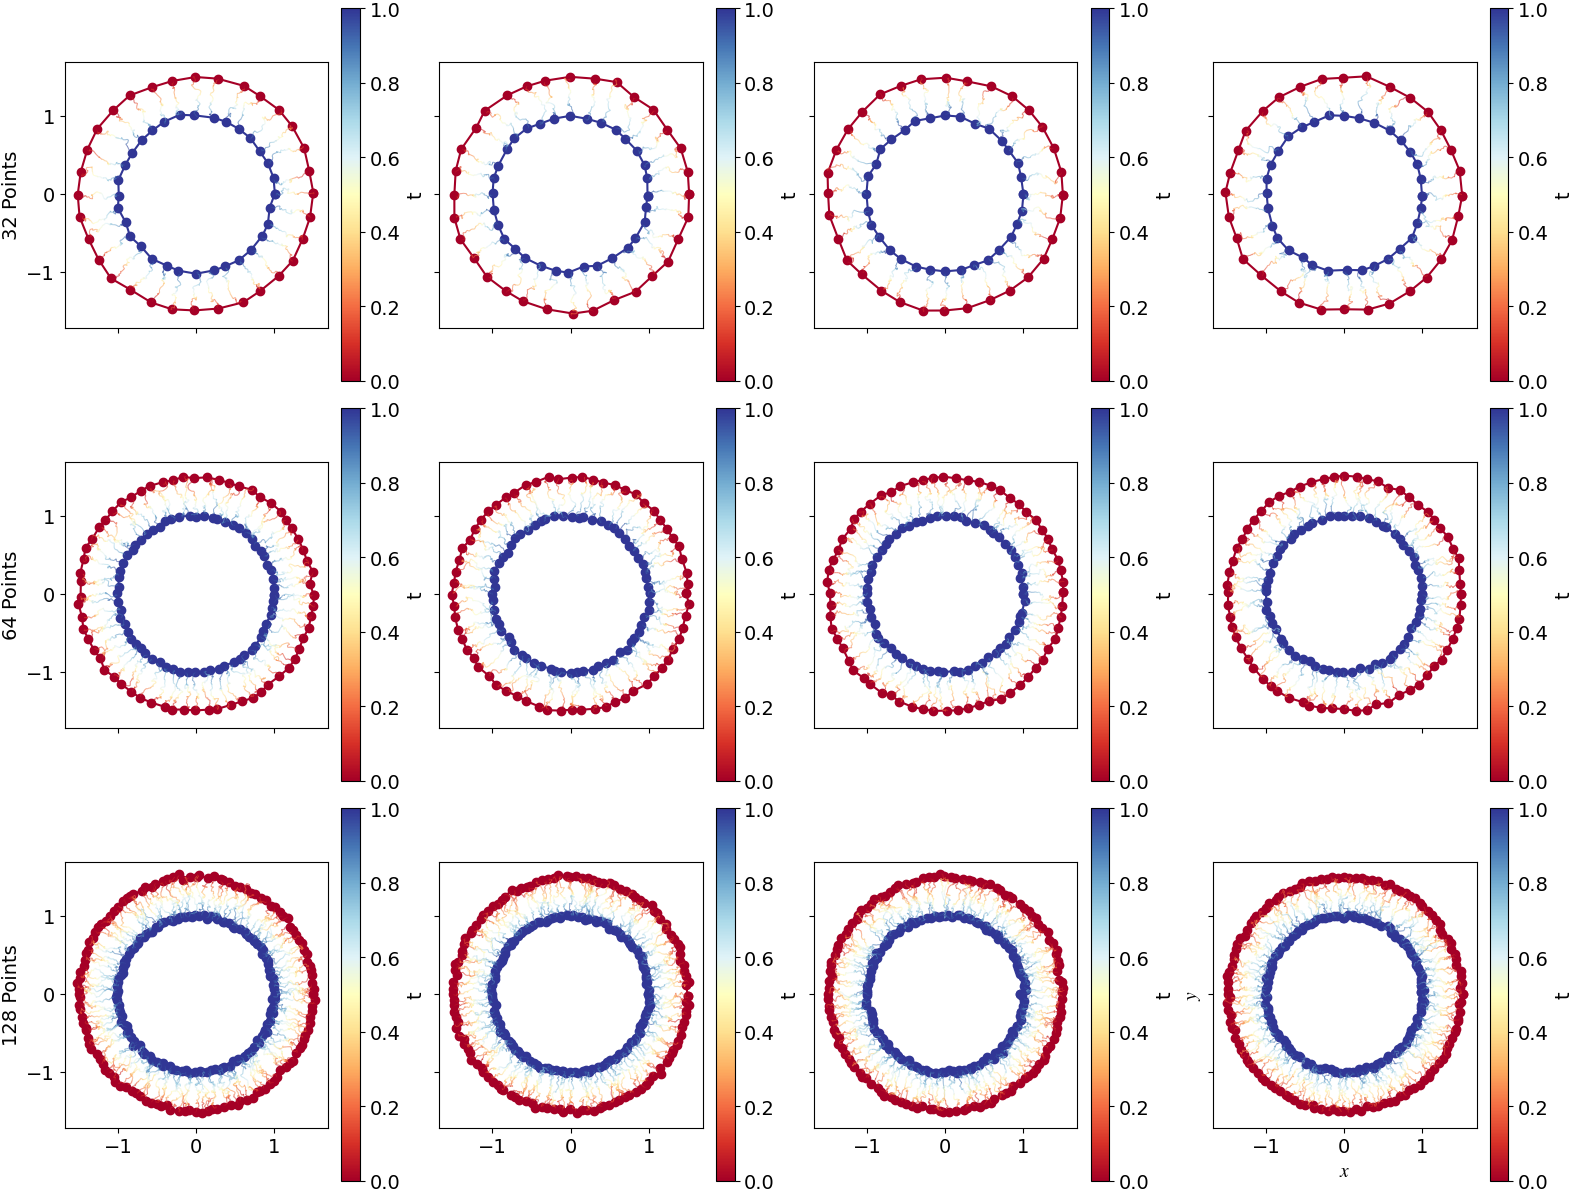

In [70]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
for i in range(4):
    plot_trajectories(dim=2, 
                        ax=ax[0, i], 
                        traj=yss32[i],
                        target=None,
                        cmap_name="RdYlBu")
    ax[0, i].set_aspect("equal")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(sm, ax=ax[0, i])
    cbar.set_label("t")

    plot_trajectories(dim=2,
                        ax=ax[1, i],
                        traj=yss64[i],
                        target=None,
                        cmap_name="RdYlBu")
    ax[1, i].set_aspect("equal")
    cbar = fig.colorbar(sm, ax=ax[1, i])
    cbar.set_label("t")

    plot_trajectories(dim=2,
                        ax=ax[2, i],
                        traj=yss128[i],
                        target=None,
                        cmap_name="RdYlBu")
    ax[2, i].set_aspect("equal")
    cbar = fig.colorbar(sm, ax=ax[2, i])
    cbar.set_label("t")

ax[0, 0].set_ylabel("32 Points", fontsize=14)
ax[1, 0].set_ylabel("64 Points", fontsize=14)
ax[2, 0].set_ylabel("128 Points", fontsize=14)

fig.savefig("../assets/circle_brownian_samples.pdf", bbox_inches="tight", dpi=150)